## Segmentation and region color averaging

Please download SAM checkpoint first from: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\fizza\appdata\local\temp\pip-req-build-l3eruot0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36834 sha256=546f14e73681e171eba748246634d958d8ca7f23189a539070405de78e22cb56
  Stored in directory: C:\Users\fizza\AppData\Local\Temp\pip-ephem-wheel-cache-opa6rx7r\wheels\10\cf\59\9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\fizza\AppData\Local\Temp\pip-req-build-l3eruot0'


In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [13]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

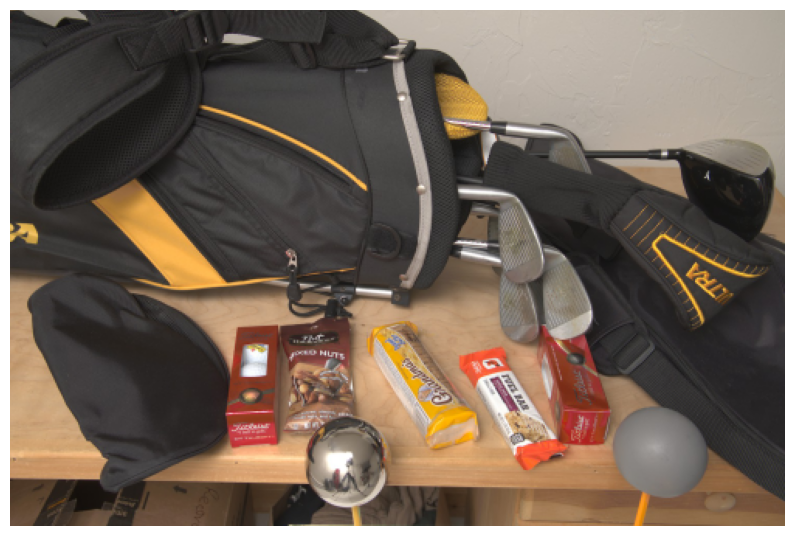

In [46]:
name = "everett_lobby12_dir_0_mip2"
image = cv2.imread(rf'dataset\Multi-Illumination\{name}.jpg')
image = cv2.resize(image, (int(image.shape[1]/3), int(image.shape[0]/3)), interpolation=cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [16]:
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


c:\Users\fizza\anaconda3\envs\iid\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [17]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.6,
    stability_score_thresh=0.85,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [47]:
masks = mask_generator.generate(image)
len(masks)

201

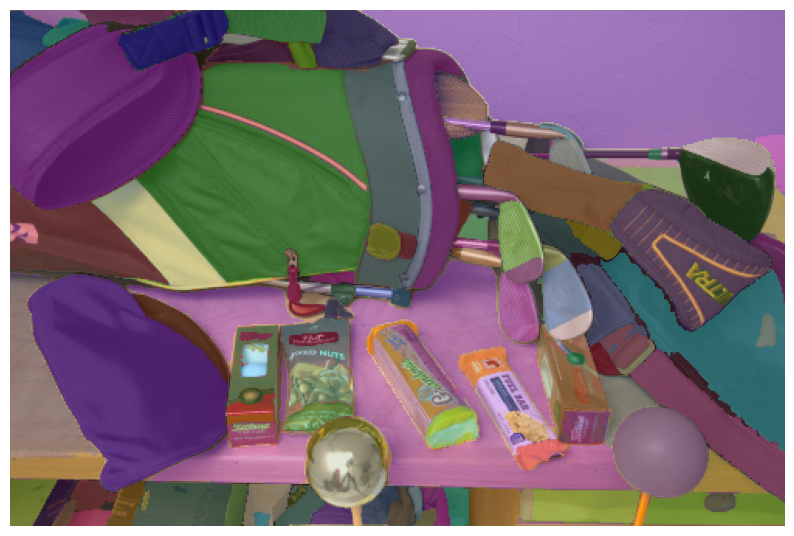

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [28]:
image.shape

(333, 500, 3)

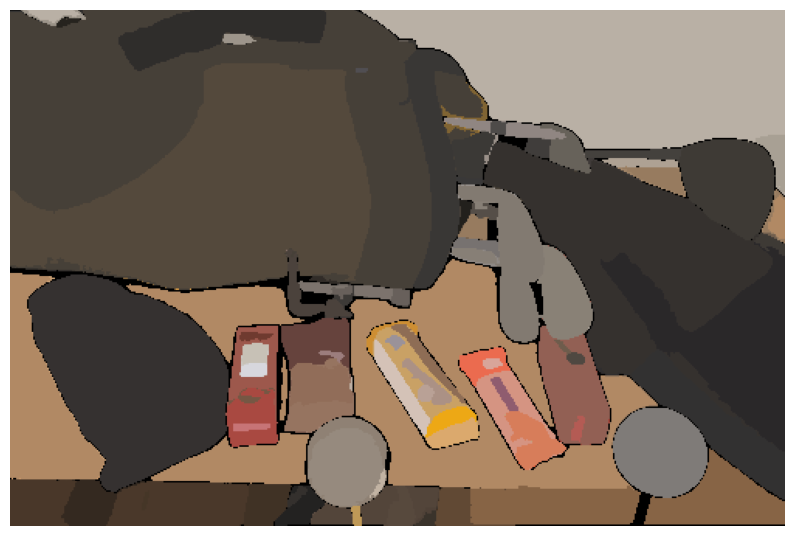

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def create_average_color_mask(image, masks):
    result = np.zeros_like(image, dtype=np.float32)
    for mask in masks:
        segmentation = mask['segmentation']
        average_color = image[segmentation].mean(axis=0)
        result[segmentation] = average_color
    # result = (result).astype(np.uint8)
    return result

# Create the averaged mask-colored image
average_mask_image = create_average_color_mask(image, masks)
plt.figure(figsize=(10, 10))
plt.imshow(average_mask_image)
plt.axis('off')
# plt.title("Image with Averaged Mask Colors")
plt.show()


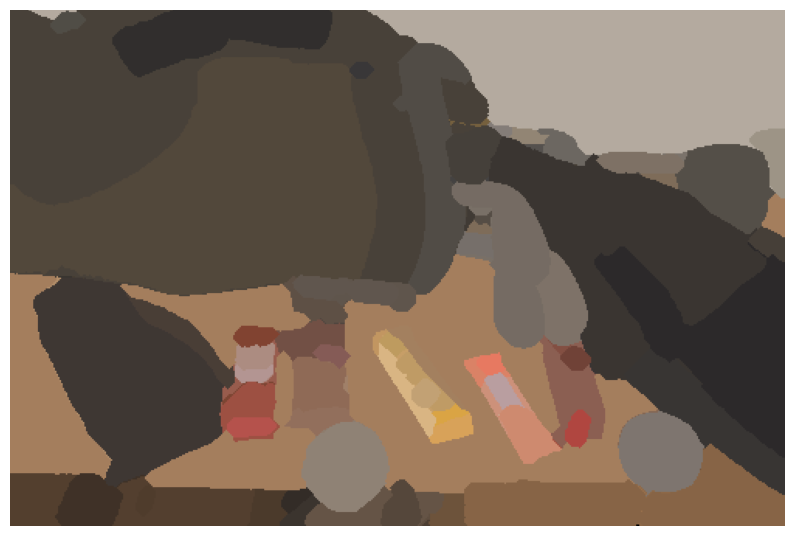

In [52]:
from scipy.ndimage import binary_dilation

def create_average_color_mask_with_dilation(image, masks, dilation_iterations=1):
    """
    Create an average color mask, with masks slightly enlarged via dilation
    to prevent gaps in the composited output.

    Args:
        image (numpy.ndarray): Input image in 0-255 range (H, W, 3).
        masks (list[dict]): List of masks from SamAutomaticMaskGenerator.
        dilation_iterations (int): Number of iterations for mask dilation.

    Returns:
        numpy.ndarray: Composited image with average colors.
    """
    result = np.zeros_like(image, dtype=np.float32)

    for mask in masks:
        segmentation = mask['segmentation']

        # Dilate the segmentation mask
        dilated_segmentation = binary_dilation(segmentation, iterations=dilation_iterations)

        # Select pixels within the dilated mask
        mask_pixels = image[dilated_segmentation]

        # Calculate the average color
        average_color = mask_pixels.mean(axis=0) if mask_pixels.size > 0 else np.array([0.5, 0.5, 0.5])

        # Apply the average color to the dilated region
        result[dilated_segmentation] = average_color

    return result

output_image = create_average_color_mask_with_dilation(image, masks, 4)
cv2.imwrite(rf'results\Multi-Illumination\Segmentation\{name}_reflectance.png', 255*cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()


True

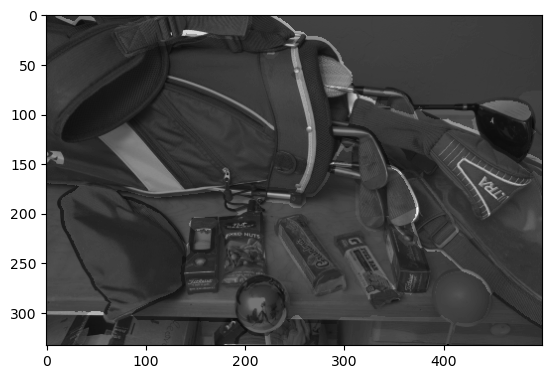

In [53]:
shading=np.divide(image.astype(float), output_image.astype(float), out=np.zeros_like(image.astype(float)), where=output_image!=0).mean(axis=-1)
plt.imshow(shading, cmap="gray")
cv2.imwrite(rf'results\Multi-Illumination\Segmentation\{name}_shading.png', 255*shading)